In [8]:
import re
import json
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time 
import os
import sagemaker
import torch

from torch import nn, optim
from sagemaker import get_execution_role

In [9]:
print(sagemaker. __version__)

2.203.1


# Set up environment

Set up a S3 bucket to upload training datasets and save training output data

In [12]:
sagemaker_session = sagemaker.Session()

role = get_execution_role()

arn:aws:iam::339713112136:role/ProteinSeqClassif_BERT_Transformer_NLP_Role


In [13]:
bucket = sagemaker_session.default_bucket() # Set a default S3 bucket
prefix = 'ProteinSeqClassif/BERT_Transformers_NLP'

In [14]:
RANDOM_SEED = 43
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Download data

In [38]:
!wget https://services.healthtech.dtu.dk/services/DeepLoc-1.0/deeploc_data.fasta -P ./data 

--2024-01-14 01:26:26--  https://services.healthtech.dtu.dk/services/DeepLoc-1.0/deeploc_data.fasta
Resolving services.healthtech.dtu.dk (services.healthtech.dtu.dk)... 192.38.87.75
Connecting to services.healthtech.dtu.dk (services.healthtech.dtu.dk)|192.38.87.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7650134 (7.3M)
Saving to: ‘./data/deeploc_data.fasta’

100%[======================================>] 7,650,134   6.50MB/s   in 1.1s   

2024-01-14 01:26:28 (6.50 MB/s) - ‘./data/deeploc_data.fasta’ saved [7650134/7650134]



In [80]:
import Bio

def read_fasta(file_path, columns):
    #Leverage Bio.SeqIO.FastaIO library to read dataset
    from Bio.SeqIO.FastaIO import SimpleFastaParser
    with open(file_path) as fasta_file:
        records = []
        for title, sequence in SimpleFastaParser(fasta_file):
            record = []
            title_splits = title.split(None)
            record.append(title_splits[0]) # first word is ID
            sequence = " ".join(sequence) # each character of protein sequence is seperated with space; will be useful for BERT tokenizer later
            record.append(sequence)
            record.append(len(sequence))
            location_splits = title_splits[1].split("-")
            record.append(location_splits[0]) # second word is location
            record.append(location_splits[1]) # third word is membrane
            
            if len(title_splits)>2:
                record.append(0)
            else:
                record.append(1)
            
            records.append(record)
    return pd.DataFrame(records, columns = columns)
                
data = read_fasta("./data/deeploc_data.fasta", columns=["id","sequence", "sequence_length", "location", "membrane", "is_train"])
data.head()

,id,sequence,sequence_length,location,membrane,is_train
0,Q9H400,M G L P V S W A P P A L W V L G C C A L L L S ...,589,Cell.membrane,M,0
1,Q5I0E9,M E V L E E P A P G P G G A D A A E R R G L R ...,1131,Cell.membrane,M,1
2,P63033,M M K T L S S G N C T L N V P A K N S Y R M V ...,531,Cell.membrane,M,1
3,Q9NR71,M A K R T F S N L E T F L I F L L V M M S A I ...,1559,Cell.membrane,M,1
4,Q86XT9,M G N C Q A G H N L H L C L A H H P P L V C A ...,479,Cell.membrane,M,1


# Data Exploration

In [81]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14004 entries, 0 to 14003
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               14004 non-null  object
 1   sequence         14004 non-null  object
 2   sequence_length  14004 non-null  int64 
 3   location         14004 non-null  object
 4   membrane         14004 non-null  object
 5   is_train         14004 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 656.6+ KB


In [82]:
data.isnull().values.any() #check whether there's any missing values

False

In [83]:
unique_classes = data.location.unique() #number of unique subcellular localization
print("Number of classes:", len(unique_classes)) 
unique_classes

Number of classes: 10


array(['Cell.membrane', 'Cytoplasm', 'Endoplasmic.reticulum',
       'Golgi.apparatus', 'Lysosome/Vacuole', 'Mitochondrion', 'Nucleus',
       'Peroxisome', 'Plastid', 'Extracellular'], dtype=object)

/tmp/ipykernel_26373/2386233676.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(data['sequence_length'].values)


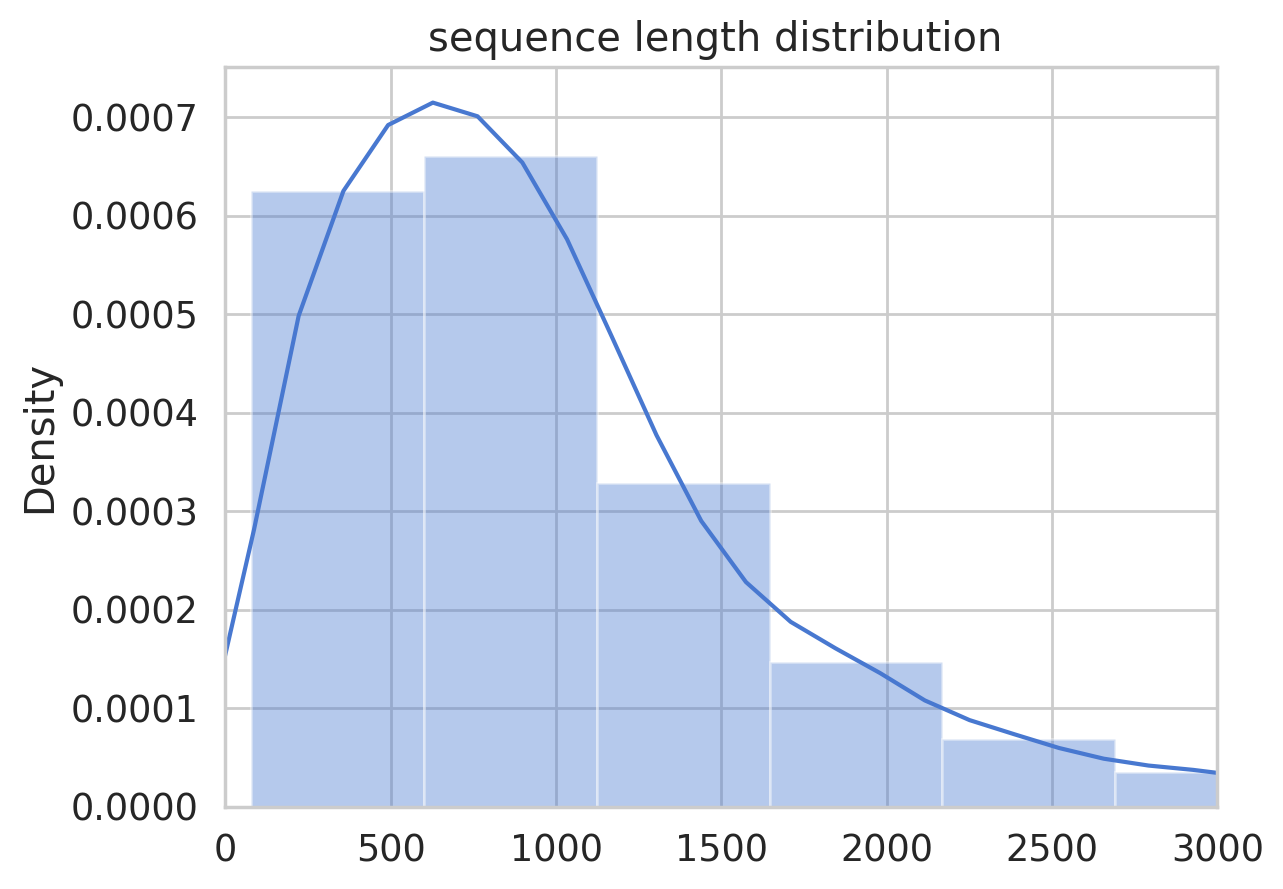

In [84]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
ax = sns.distplot(data['sequence_length'].values)
ax.set_xlim(0, 3000)
plt.title(f'sequence length distribution ')
plt.grid(True)

In [85]:
#factorize protein classes
categories = data.location.astype('category').cat
data['location'] = categories.codes 
class_names = categories.categories 
num_classes = len(class_names)
print(class_names)

Index(['Cell.membrane', 'Cytoplasm', 'Endoplasmic.reticulum', 'Extracellular',
       'Golgi.apparatus', 'Lysosome/Vacuole', 'Mitochondrion', 'Nucleus',
       'Peroxisome', 'Plastid'],
      dtype='object')


In [86]:
df_train = data[data.is_train == 1]
df_train = df_train.drop(["is_train"], axis = 1) #so df_train no longer contains the is_train column
df_train.shape[0]


11231

In [89]:
df_test = data[data.is_train == 0]
df_test = df_test.drop(["is_train"], axis = 1) 
df_test.shape[0] #75:25 split between train and test

2773

# Upload Data to S3

In [95]:
train_dataset_path = 'data/deeploc_per_protein_train.csv'
test_dataset_path = 'data/deeploc_per_protein_test.csv'
df_train.to_csv(train_dataset_path)
df_test. to_csv(test_dataset_path)
#upload the CSV files to an S3 bucket
inputs_train = sagemaker_session.upload_data(train_dataset_path, bucket=bucket, key_prefix=prefix) 
inputs_test = sagemaker_session.upload_data(test_dataset_path, bucket=bucket, key_prefix=prefix)

In [98]:
print("S3 location for training data: ", inputs_train) 
print ("S3 location for testing data: ", inputs_test )

S3 location for training data:  s3://sagemaker-us-east-2-339713112136/ProteinSeqClassif/BERT_Transformers_NLP/deeploc_per_protein_train.csv
S3 location for testing data:  s3://sagemaker-us-east-2-339713112136/ProteinSeqClassif/BERT_Transformers_NLP/deeploc_per_protein_test.csv


# Training script

#### I use the PyTorch-Transformers library, specifically PyTorch and the pre-trained ProtBert model on protein sequences.

In [ ]:
import torch
from transformers import BertModel, BertTokenizer

model_name = "Rostlab/prot_bert"  # ProtBert model
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)


tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/361 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.68G [00:00<?, ?B/s]